In [1]:
import glob, os
test_data_files = []
for file in glob.glob("/Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/*/eval/*.edf"):
    test_data_files.append(file)
print(len(test_data_files))

train_data_files = []
for file in glob.glob("/Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/*/train/*.edf"):
    train_data_files.append(file)
print(len(train_data_files))

185
2232


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import mne
import numpy as np

data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=40, verbose=False)#.resample(sfreq=100)
data = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
data = data.get_data()
data.shape

Using data from preloaded Raw for 846 events and 200 original time points ...
0 bad epochs dropped


(846, 21, 200)

In [4]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant


def calcGrangerCausality(eegData,ii,jj):
    #eegData = np.diff(eegData)
    gc_avg = []
    for epoch_idx, epoch in enumerate(eegData):
        if epoch_idx%2 == 0:
            X = np.vstack([epoch[ii,:],epoch[jj,:]]).T
            gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][1]
            gc_avg.append(gc)
    gc_avg = np.mean(gc_avg)
    return gc_avg
    
def get_label(file):
    label = file.split("/")[-3]
    if label == "normal":
        return [0]
    elif label == "abnormal":
        return [1]

    
def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False).resample(sfreq=fs)
        data_epochs = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
        data = data.get_data()
        data_epochs = data_epochs.get_data()
        if data_epochs.shape[0] > 20:
            data_epochs = data_epochs[:20]

        gc = []
        for i in range(21):
            gc1 = []
            for j in range(21):
                gc1.append(calcGrangerCausality(data_epochs, i, j))
            gc.append(gc1)
        data_graphs.append(gc)    
        
        
        ch_features = []    
        # freq domain features
        sf = 256
        win = 4 * sf # win size 4 seconds * sampling freq
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
                
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
        
            
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [518]:
#%%capture
np.random.seed(42)
train_X, train_graphs, train_y = build_data(train_data_files)
test_X, test_graphs, test_y = build_data(test_data_files)

  0%|                                                                           | 0/1 [00:00<?, ?it/s]

Using data from preloaded Raw for 840 events and 100 original time points ...
0 bad epochs dropped


/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.30s/it]


In [6]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((185, 21, 7),
 (2232, 21, 7),
 (2232, 21, 21),
 (185, 1),
 (2232, 1),
 (185, 21, 21))

In [7]:
test_X.min(), train_X.min(), test_X.max(), train_X.max()

(-0.10262589690892014, 0.0, 1.3026285473939159, 1.0)

In [410]:
#np.save("../conn_data/gc/train_X.npy", train_X)
#np.save("../conn_data/gc/test_X.npy", test_X)
#np.save("../conn_data/gc/train_y.npy", train_y)
#np.save("../conn_data/gc/test_y.npy", test_y)
#np.save("../conn_data/gc/train_graphs.npy", train_graphs)
#np.save("../conn_data/gc/test_graphs.npy", test_graphs)

In [5]:
train_X = np.load("../conn_data/gc/train_X.npy")
test_X = np.load("../conn_data/gc/test_X.npy")
train_y = np.load("../conn_data/gc/train_y.npy")
test_y = np.load("../conn_data/gc/test_y.npy")
train_graphs = np.load("../conn_data/gc/train_graphs.npy")
test_graphs = np.load("../conn_data/gc/test_graphs.npy")

0


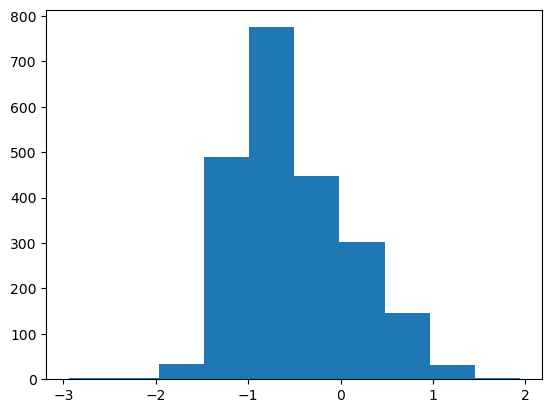

1


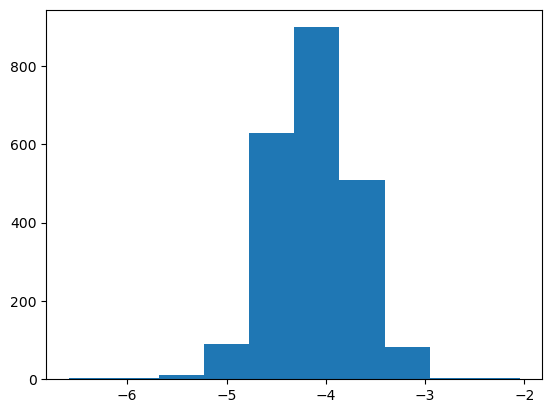

2


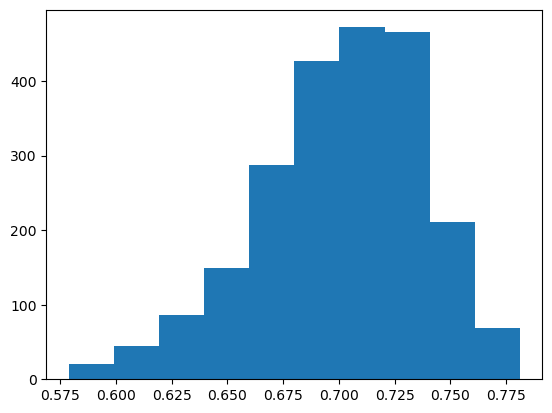

3


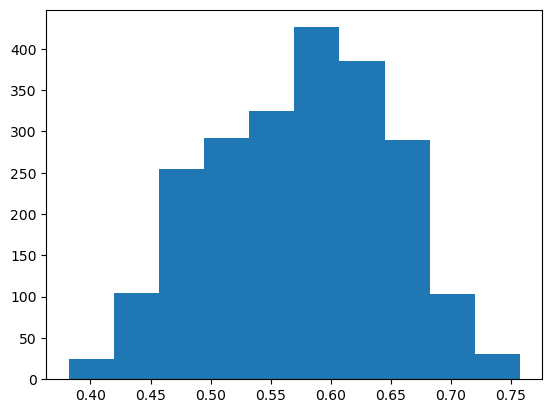

4


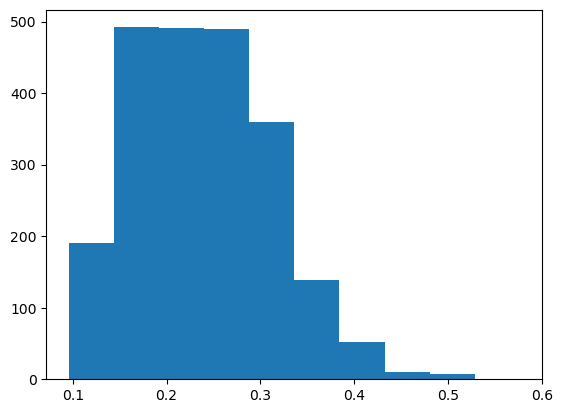

5


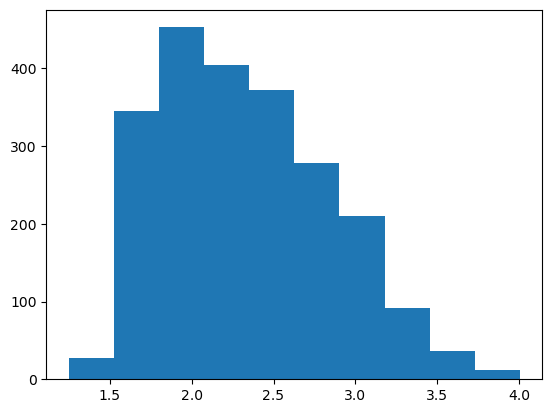

6


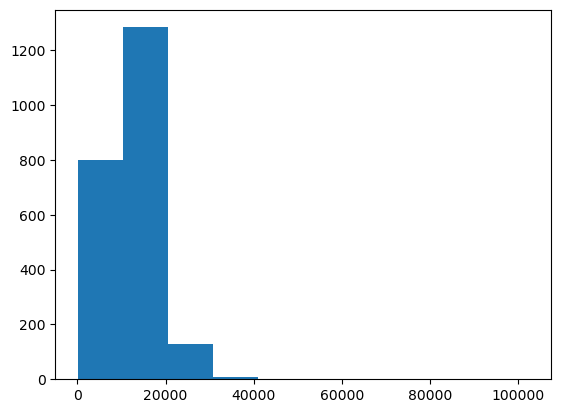

In [51]:
import matplotlib.pyplot as plt
for i in range(7):
    print(i)
    plt.hist(train_X[:, 4, i])
    plt.show()

In [8]:
import torch
import copy

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j]) #+ 0.000000000000001
        
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)    
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [9]:
train_X.shape, test_X.shape

((2232, 21, 7), (185, 21, 7))

In [10]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 1.3026285473939159, 0.0, -0.10262589690892014)

In [11]:
from tqdm import tqdm
train_X, test_X = standardize_data(train_X, test_X)

train_X.shape

100%|███████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1730.22it/s]


(2232, 21, 7)

In [12]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [13]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 1.3026285473939159, 0.0, -0.10262589690892014)

In [14]:
train_graphs.max(), train_graphs.min(), test_graphs.max(), test_graphs.min()

(1.0, 0.0, 1.0, 1.2204235314733133e-07)

In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            #y = y.long()
            #y = y.float()
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
        
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds,  average='weighted'), 
            recall_score(ytrue, ypreds,  average='weighted'),
            f1_score(ytrue, ypreds,  average='weighted'))

# Vis

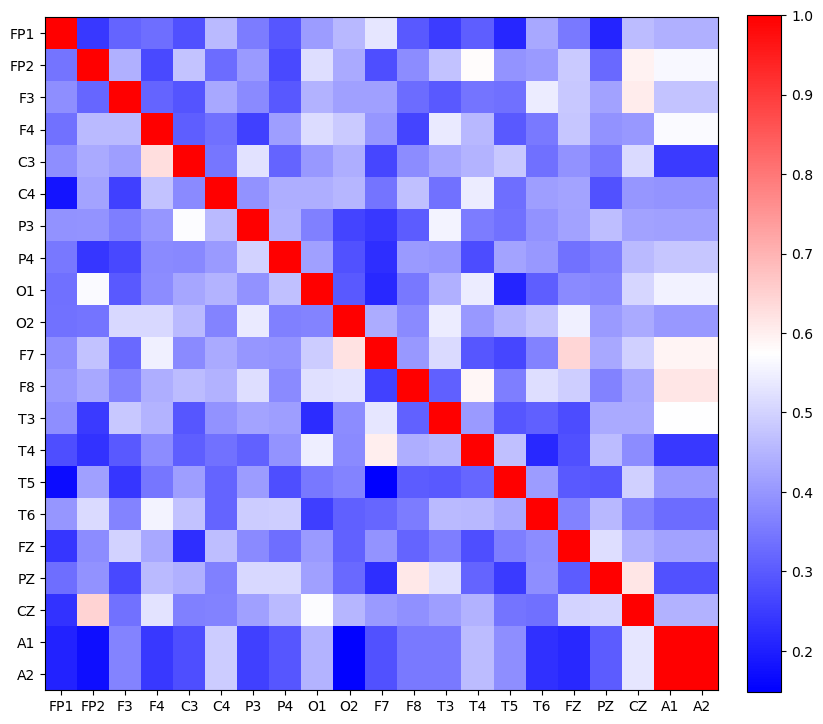

label:  [1]


In [436]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[7], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
fig.savefig("abnormal3.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[7])

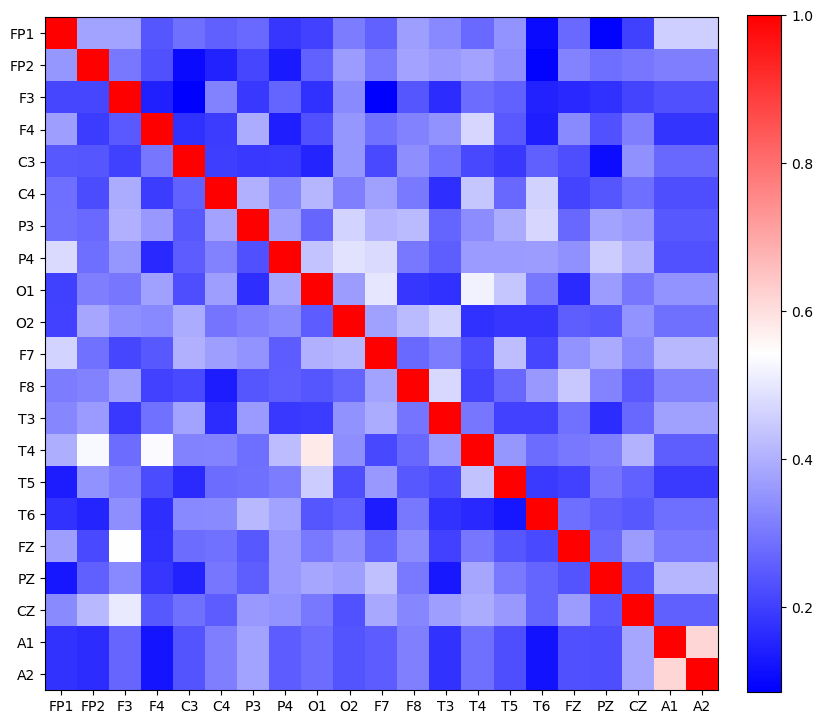

label:  [1]


In [440]:
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[77], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
fig.savefig("abnormal3.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[77])

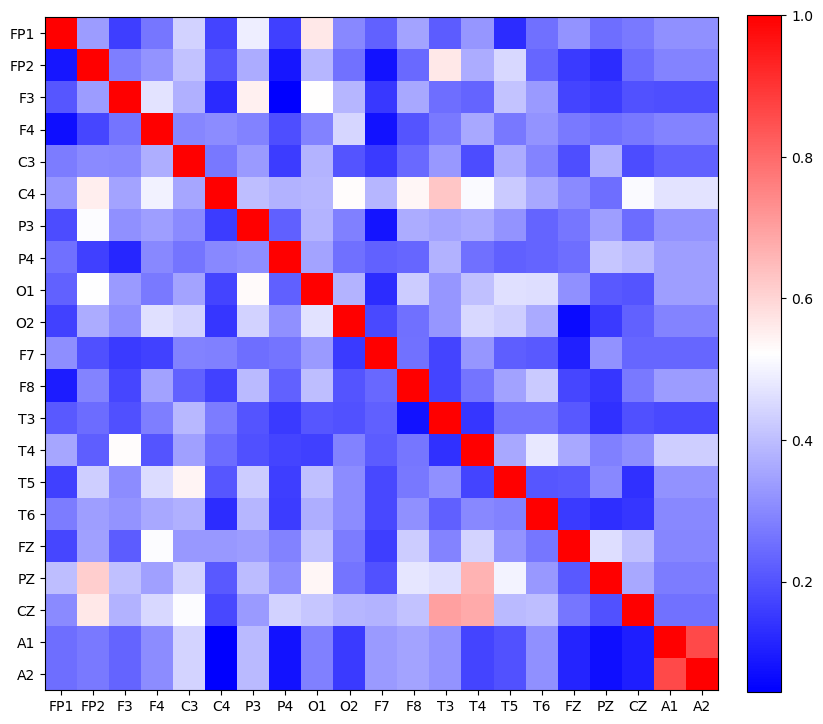

label:  [1]


In [441]:
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[55], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
fig.savefig("abnormal3.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[55])

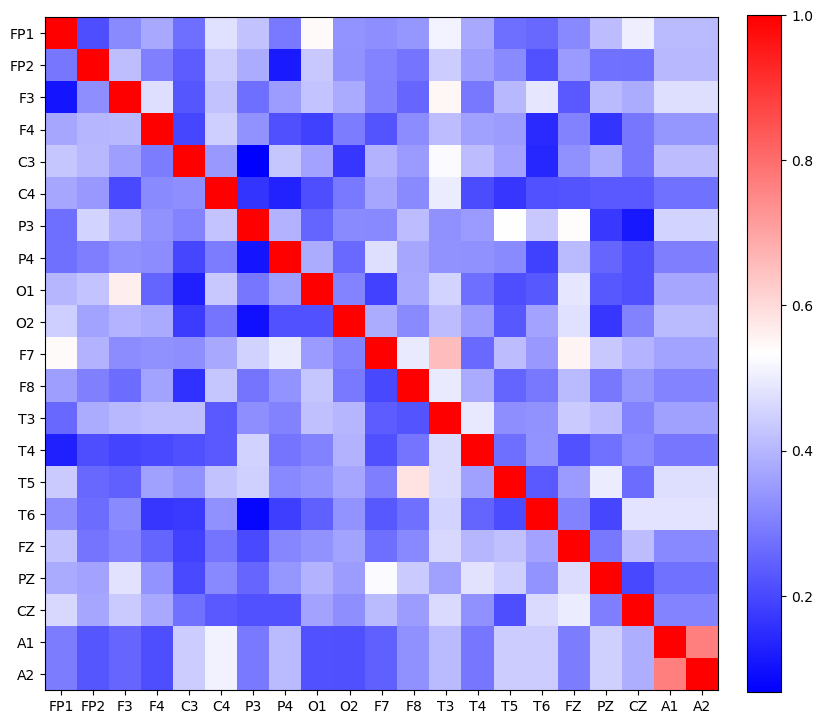

label:  [0]


In [438]:
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[-7], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
fig.savefig("abnormal3.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[-7])

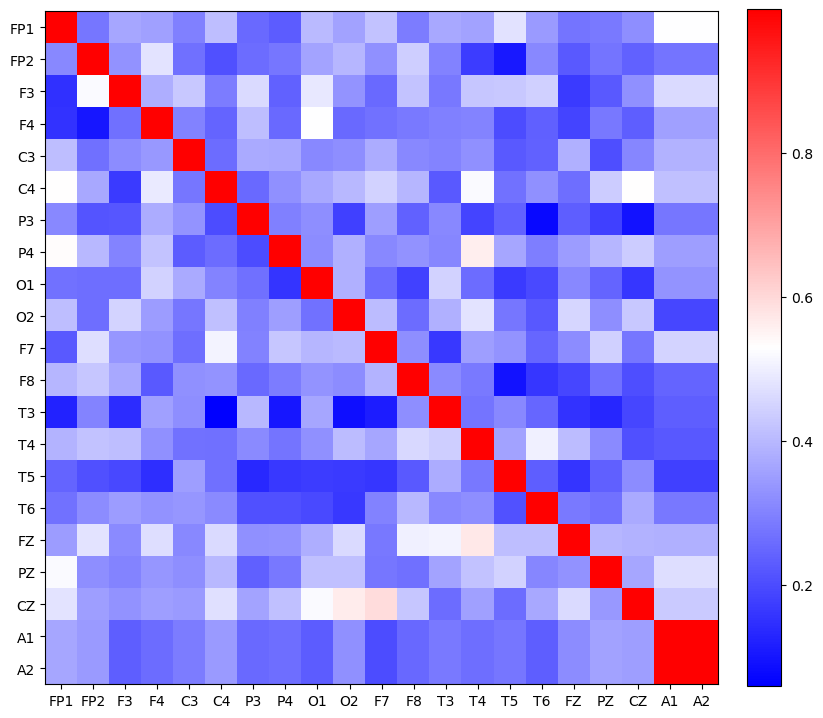

label:  [0]


In [439]:
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[-15], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
fig.savefig("abnormal3.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[-15])

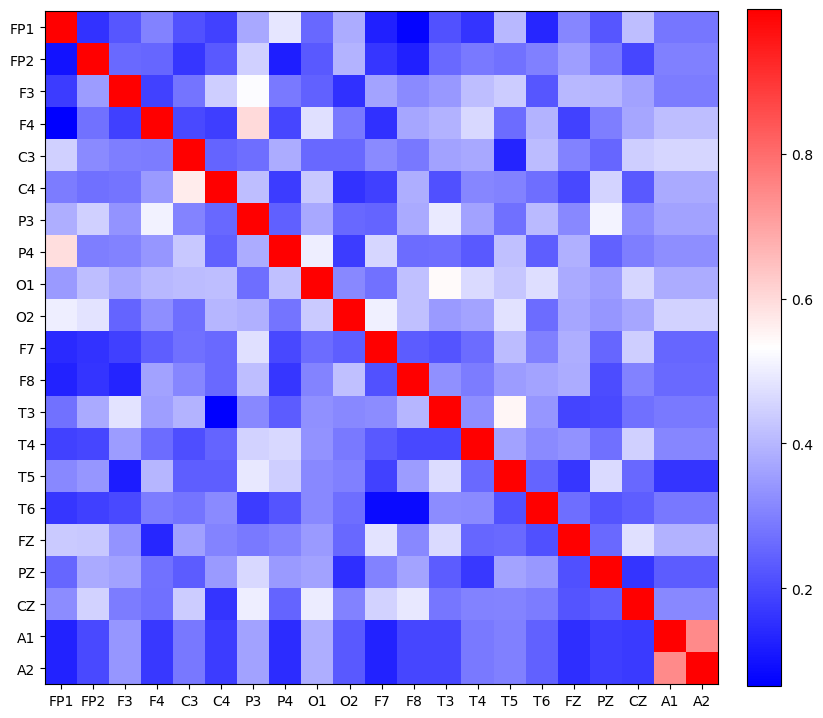

label:  [0]


In [442]:
fig, ax = plt.subplots(figsize=(9.5,9.5))
# create an index for each tick position
my_xticks = ['FP1', 'FP2', 'F3','F4','C3','C4','P3','P4','O1','O2','F7','F8','T3','T4','T5','T6','FZ','PZ','CZ','A1','A2']
x = range(21)

plt.xticks(x, my_xticks)
plt.yticks(x, my_xticks)

im = ax.imshow(train_graphs[-55], cmap='bwr', interpolation='nearest')
fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)
fig.savefig("abnormal3.pdf", bbox_inches='tight')

plt.show()

print("label: ", train_y[-55])

Here we measure the average cosine similaity within each class (normal and abnormal)

In [461]:
from scipy.spatial import distance

normal_graphs = []
abnormal_graphs = []
for y, g in zip(train_y, train_graphs):
    if y[0] == 0:
        normal_graphs.append(g)
    else:
        abnormal_graphs.append(g)
        
normal_cos = []
abnormal_cos = []
for g1idx, g1 in enumerate(tqdm(normal_graphs)):
    for g2idx, g2 in enumerate(normal_graphs):
        if not g1idx == g2idx:
            c = distance.cosine(g1.flatten(), g2.flatten())
            normal_cos.append(c)
            
for g1idx, g1 in enumerate(tqdm(abnormal_graphs)):
    for g2idx, g2 in enumerate(abnormal_graphs):
        if not g1idx == g2idx:
            c = distance.cosine(g1.flatten(), g2.flatten())
            abnormal_cos.append(c)

print(np.mean(abnormal_cos))
print(np.mean(normal_cos))

100%|██████████████████████████████████████████████████████████████| 355/355 [00:03<00:00, 116.73it/s]


0.0756569568275781
0.07101623591856113


Here we calculate the cosine similarity between each data point in the two classes

In [462]:
normal_abnormal_cos = []
for g1 in tqdm(abnormal_graphs):
    for g2 in normal_graphs:
        c = distance.cosine(g1.flatten(), g2.flatten())
        normal_abnormal_cos.append(c)
print(np.mean(normal_abnormal_cos))

100%|███████████████████████████████████████████████████████████████| 355/355 [00:15<00:00, 22.77it/s]


0.07370853409452412


# Training Neural Network using GC as adjacency matrix

In [429]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN

NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

#print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    #print("KFold ", i)
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 128, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        #print("Epoch", epoch) 
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

  0%|                                                                        | 0/1000 [00:00<?, ?it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|                                                                        | 0/1000 [00:00<?, ?it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


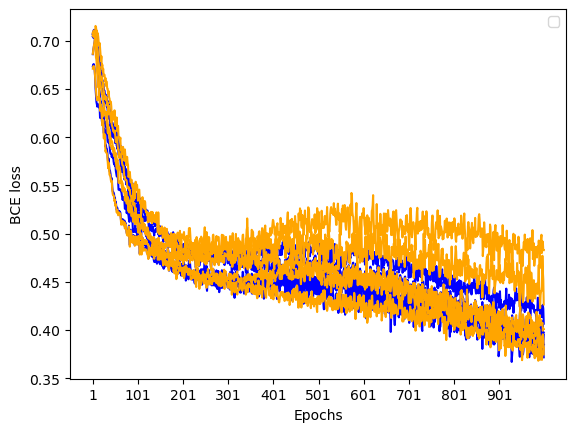

In [430]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


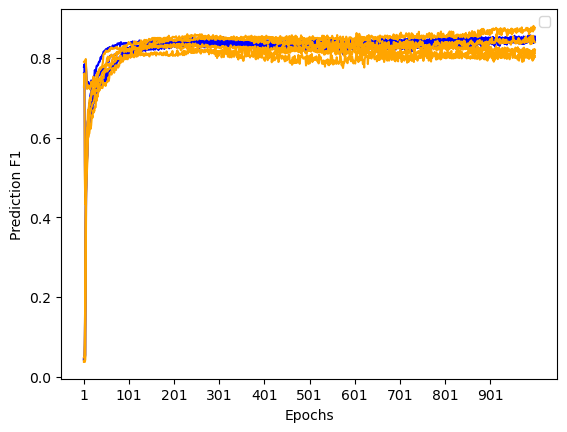

In [431]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("Prediction F1")
plt.legend(loc="upper right")
plt.show()

In [432]:
#%%capture
print("Training Model....")
from model import ChebNetGCN

NUM_EPOCHS = 250
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 128, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in range(1, NUM_EPOCHS + 1):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        #y = y.squeeze()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss#.item()
        loss.backward()
        optimizer.step()

Training Model....


In [433]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.8315412186379928
Precision:  0.8519134716852286
Recall:  0.8315412186379928
F1:  0.839769239282755
Confusion Matrix:  [[1638  239]
 [ 137  218]]


In [434]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8108108108108109
Precision:  0.8208137197863226
Recall:  0.8108108108108109
F1:  0.8087137550994579
Confusion Matrix:  [[86  9]
 [26 64]]


## Corr

In [ ]:
import numpy as np

def build_graphs(raw_data):
    
    fs = 100
    
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=47, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        corr = []
        for i in range(21):
            corr1 = []
            for j in range(21):
                corr1.append(np.correlate(data[i], data[j])[0])
            corr.append(corr1)
        data_graphs.append(corr)    
        
    data_graphs = np.array(data_graphs)
    
    return data_graphs

train_corr_graphs = build_graphs(train_data_files)
test_corr_graphs = build_graphs(test_data_files)

In [17]:
#np.save("../conn_data/corr/train_graphs.npy", train_corr_graphs)
#np.save("../conn_data/corr/test_graphs.npy", test_corr_graphs)

train_graphs = np.load("../conn_data/corr/train_graphs.npy")
test_graphs = np.load("../conn_data/corr/test_graphs.npy")

In [18]:
train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [22]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
from model import ChebNetGCN


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 128, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


  0%|                                                                        | 0/1000 [00:00<?, ?it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  0%|                                                                | 1/1000 [00:00<16:24,  1.02it/s]/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


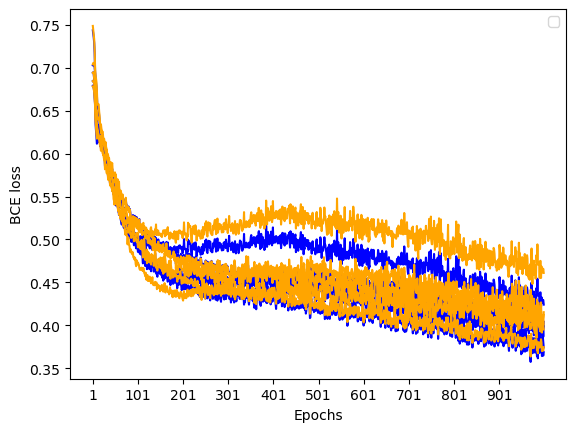

In [23]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


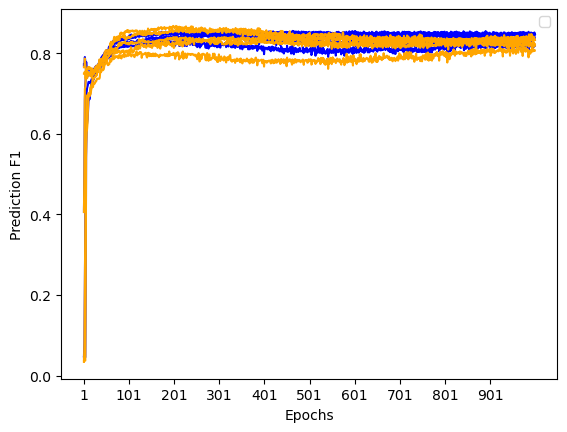

In [24]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("Prediction F1")
plt.legend(loc="upper right")
plt.show()

In [19]:
#%%capture
print("Training Model....")
from model import ChebNetGCN

NUM_EPOCHS = 250
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 128, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in range(1, NUM_EPOCHS + 1):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        #y = y.squeeze()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss#.item()
        loss.backward()
        optimizer.step()

Training Model....


In [20]:
train_acc = cal_accuracy(model, train_iter)
print("Accuracy: ", train_acc[0])
print("Precision: ", train_acc[2])
print("Recall: ", train_acc[3])
print("F1: ", train_acc[4])
print("Confusion Matrix: ", train_acc[1])

Accuracy:  0.8293010752688172
Precision:  0.8521751741317793
Recall:  0.8293010752688172
F1:  0.8383709169827271
Confusion Matrix:  [[1630  247]
 [ 134  221]]


In [21]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8054054054054054
Precision:  0.8139761383004627
Recall:  0.8054054054054054
F1:  0.8034700577916302
Confusion Matrix:  [[85 10]
 [26 64]]
